In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [33]:
#X is the preprocessed data used to generate clusters
#y is the generated cluster labels
X = pd.read_csv('X.csv')
y = pd.read_csv('labels.csv')

In [34]:
def get_NN_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(15, input_dim=n_inputs, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

@ignore_warnings(category=ConvergenceWarning)
def CrossValidation_Evaluation(X, y, models):
    cv = RepeatedKFold(n_splits=5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    results_dict = {}
    for model_name, model_instance in models.items():
        results = []        
        if model_name == 'NN':
            for train_ix, test_ix in cv.split(X_train):
                X_train_fold, X_val_fold = X_train.iloc[train_ix], X_train.iloc[test_ix]
                y_train_fold, y_val_fold = np.array(pd.Series(y_train).iloc[train_ix]), np.array(pd.Series(y_train).iloc[test_ix])

                num_classes = len(np.unique(y_train_fold))
                y_train_encoded = to_categorical(y_train_fold, num_classes=num_classes)
                y_val_encoded = to_categorical(y_val_fold, num_classes=num_classes)

                n_inputs = X_train_fold.shape[1]
                n_outputs = num_classes
                model = get_NN_model(n_inputs, n_outputs)

                history = model.fit(X_train_fold, y_train_encoded, verbose=0, epochs=30, validation_data=(X_val_fold, y_val_encoded))

                test_loss, test_accuracy = model.evaluate(X_test, to_categorical(y_test, num_classes=num_classes), verbose=0)
                results.append(test_accuracy)
            results_dict[model_name] = round(np.mean(results) * 100, 2)
            print(f"{model_name} test accuracy: {results_dict[model_name]}%")            
        else:
            for train_ix, test_ix in cv.split(X_train):
                X_train_fold, X_val_fold = X_train.iloc[train_ix], X_train.iloc[test_ix]
                y_train_fold, y_val_fold = np.array(pd.Series(y_train).iloc[train_ix]), np.array(pd.Series(y_train).iloc[test_ix])

                model_instance.fit(X_train_fold, y_train_fold)

                # Evaluate on the test set
                y_pred = model_instance.predict(X_test)

                accuracy = model_instance.score(X_test, y_test)
                results.append(accuracy)

            results_dict[model_name] = round(np.mean(results) * 100, 2)
            print(f"{model_name} test accuracy: {results_dict[model_name]}%")   
    return results_dict

In [35]:
models = {
    'NN': None,
    'KNN': KNeighborsClassifier(),
    'SVC': LinearSVC(),
    'LR': LogisticRegression(),
    'NB': GaussianNB(),
    'RFC': RandomForestClassifier(),
    'DTC': DecisionTreeClassifier(),
    'XGB': XGBClassifier()
}


modelsDict = CrossValidation_Evaluation(X,y.values.ravel(),models)


NN test accuracy: 98.74%
KNN test accuracy: 98.92%
SVC test accuracy: 98.25%
LR test accuracy: 98.03%
NB test accuracy: 97.9%
RFC test accuracy: 98.47%
DTC test accuracy: 98.92%
XGB test accuracy: 98.9%


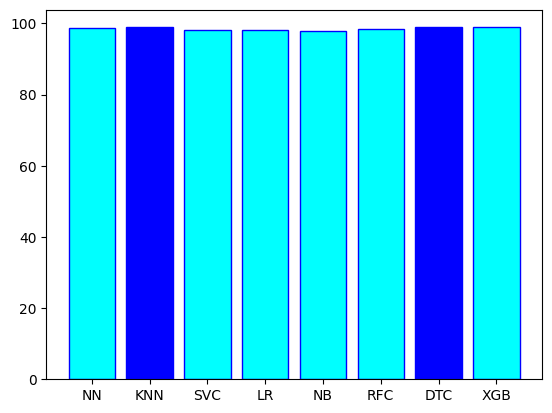

In [36]:
score = list(modelsDict.values())
bars = tuple(modelsDict.keys())
x_pos = np.arange(len(bars))

values = np.array(list(modelsDict.values()))
values = ['Cyan' if (x < max(values)) else 'blue' for x in values]

plt.bar(x_pos, score, color=values,edgecolor='blue')
plt.xticks(x_pos, bars)
plt.savefig('results.png')
plt.show()